In [ ]:
!pip install darts

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from darts.models import ARIMA
import matplotlib.pyplot as plt

In [4]:
tesla_data = yf.download('TSLA', start='2014-01-01', end='2023-11-01', interval = '1mo', progress=False)
tesla_data = tesla_data['Close']  # Nos enfocamos en los precios de cierre



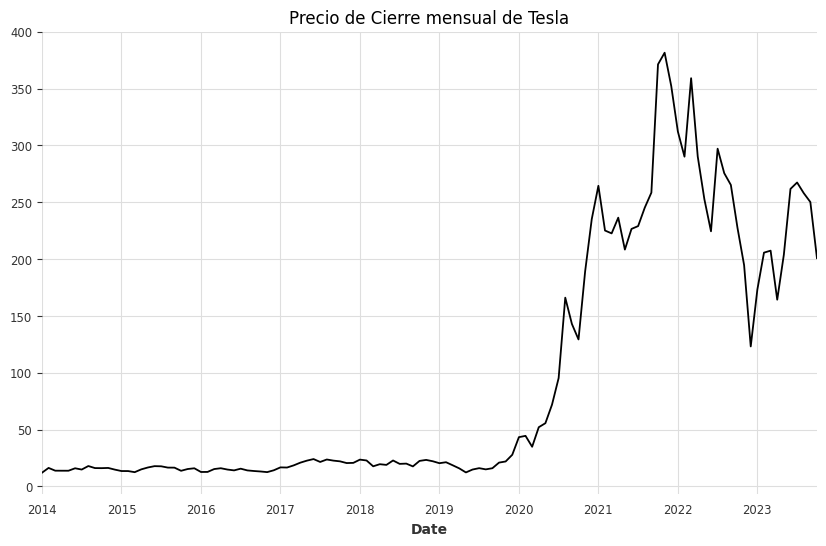

In [5]:
tesla_data.plot(figsize=(10, 6))
plt.title('Precio de Cierre mensual de Tesla')
plt.show()

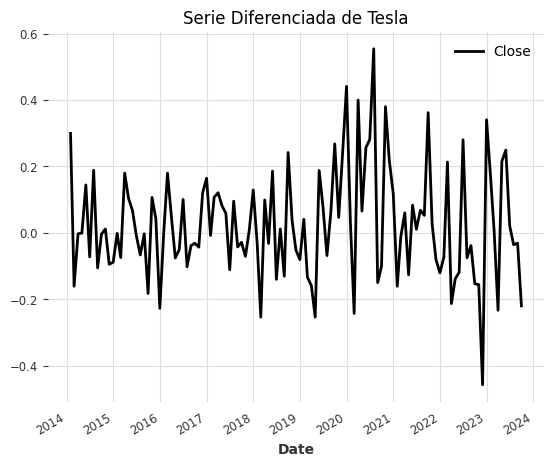

In [6]:
# Aplicando el logaritmo usando NumPy
tesla_log_data = np.log(tesla_data)

# Convirtiendo de nuevo a TimeSeries de Darts
tesla_log_ts = TimeSeries.from_series(tesla_log_data, fill_missing_dates=True)

# Diferenciando la serie logarítmica
tesla_diff = tesla_log_ts.diff()


tesla_diff.plot()
plt.title('Serie Diferenciada de Tesla')
plt.show()

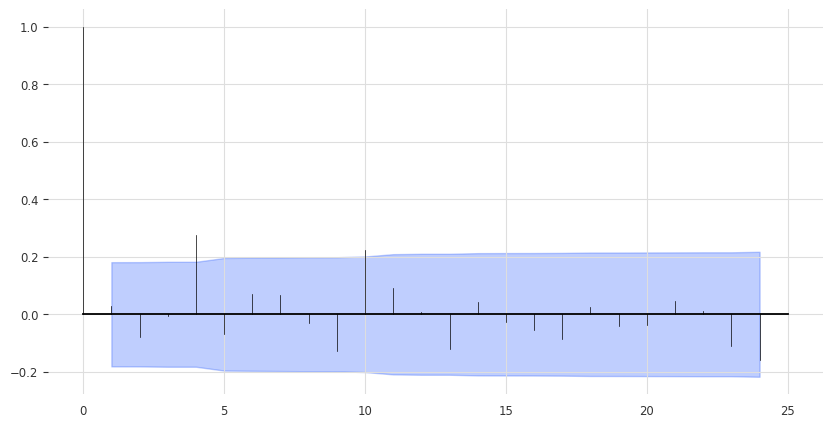

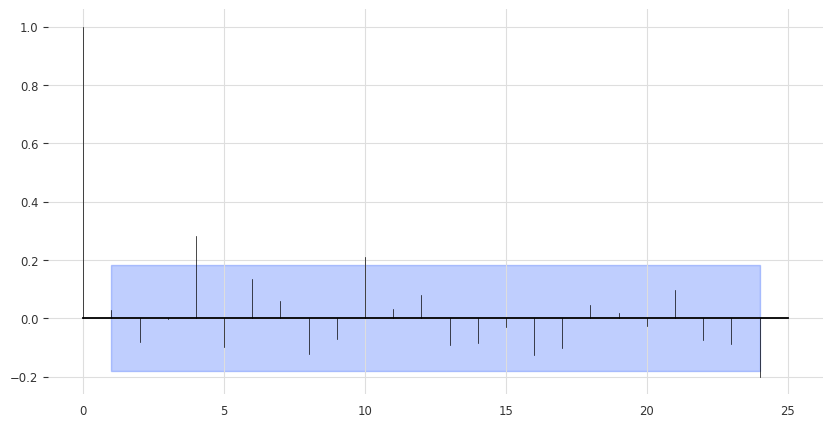

In [7]:
# Graficar ACF
plot_acf(tesla_diff)

# Graficar PACF
plot_pacf(tesla_diff)


In [8]:
import pmdarima as pm

# Convierte la serie temporal de Darts a una serie de pandas
tesla_diff_pd = tesla_diff.pd_series()

# Ajusta el modelo ARIMA utilizando auto_arima
auto_model = pm.auto_arima(tesla_diff_pd, seasonal=False, stepwise=False,
                           suppress_warnings=True,
                           error_action="ignore",
                           max_order=None,
                           trace=True,
                           start_p =0 , max_p = 4,
                           start_q=0 , max_q=4)

# Obtén el AIC del modelo ajustado
aic_value_auto = auto_model.aic()
print(f'AIC auto modelo: {aic_value_auto}')


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-86.433, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-84.742, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-82.982, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-81.038, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-92.346, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-84.704, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-83.891, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-80.984, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-84.876, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-90.399, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-83.140, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-81.146, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-82.009, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-90.595, Time=0.26 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-89.425, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0]  

In [9]:
# Obtén los parámetros estimados del modelo seleccionado
estimated_params = auto_model.arima_res_.params
print(f'Parámetros estimados: {estimated_params}')


Parámetros estimados: ma.L1     0.068013
ma.L2    -0.017649
ma.L3    -0.051494
ma.L4     0.355978
sigma2    0.024292
dtype: float64


La ecuación para $X_t$ es:

$$X_t = \epsilon_t + 0.068013 \cdot \epsilon_{t-1} - 0.017649 \cdot \epsilon_{t-2} - 0.051494 \cdot \epsilon_{t-3} + 0.355978 \cdot \epsilon_{t-4}$$
donde $\epsilon_{t} \sim RB(0, 0.024292)$ y $X_t = log(Y_t) - log(Y_{t-1})$ e $Y_t$ es el valor del precio de la acción de Tesla en el mes $t$

In [11]:
tesla_data.tail()

Date
2023-06-01    261.769989
2023-07-01    267.429993
2023-08-01    258.079987
2023-09-01    250.220001
2023-10-01    200.839996
Name: Close, dtype: float64

In [16]:
import numpy as np

# Suponiendo que model es tu modelo ARIMA ajustado
# y que Y_last es el último valor observado de Y_t

# Predice la serie diferenciada X_t para los próximos n periodos
future_diff_preds = auto_model.predict(n_periods=10)

# Integra las predicciones diferenciadas para obtener
# las predicciones del logaritmo de Y_t
log_Y_last = np.log([200.839996])
log_Y_preds = log_Y_last + np.cumsum(future_diff_preds)

# Exponencia las predicciones del logaritmo de Y_t
# para obtener las predicciones de Y_t
Y_preds = np.exp(log_Y_preds)


In [17]:
Y_preds

2023-11-01    196.380330
2023-12-01    197.569032
2024-01-01    196.414996
2024-02-01    177.667408
2024-03-01    177.667408
2024-04-01    177.667408
2024-05-01    177.667408
2024-06-01    177.667408
2024-07-01    177.667408
2024-08-01    177.667408
Freq: MS, dtype: float64